In [97]:
!pip install pandas
!pip install numpy
!pip install torch
!pip install tqdm
!pip install matplotlib
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-pac

In [98]:
from os import listdir
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader

import Sources.Utils as UtilsTool
import Sources.Attacks as AttacksTool
import Sources.Data as DataTool
from Sources.Models import RNNModel, GRUModel, LSTMModel, SingleExpDegradationModel, ExpDegradationModel

In [99]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

DisplayGraph = 1
TrainMode = 0
OptimizeParameters = 0

DatasetPath = 'DatasetRUL/'
ModelPath = 'Models/'
NormalOutputPath = 'ResultsRUL/Normal/'
AdversarialOutputPath = 'ResultsRUL/Adversarial/'
OptimalParametersPath = 'ResultsRUL/OptimalParameters/'
FiguresPath = 'ResultsRUL/Figures/'

window = 80

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [101]:
listdir(DatasetPath)

df_train = pd.read_csv(DatasetPath + 'train_FD001.txt', header = None, sep = ' ')
df_test = pd.read_csv(DatasetPath + 'test_FD001.txt', header = None, sep = ' ')
rul_test = pd.read_csv(DatasetPath + 'RUL_FD001.txt', header = None)

In [102]:
df_train, df_test, rul_test = DataTool.SetDatasets(df_train, df_test, rul_test)

In [103]:
minmax_dict = DataTool.GetMinMaxDictionnary(df_train)
Ndf_train  = DataTool.NormalizeDataset(df_train, minmax_dict)    
Ndf_test  = DataTool.NormalizeDataset(df_test, minmax_dict)   

In [104]:
n_features = len([c for c in Ndf_train.columns if 's' in c])

In [105]:
np.random.seed(5)
torch.manual_seed(5)

units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))

train_data = Ndf_train[Ndf_train['unit'].isin(train_units)].copy()
val_data = Ndf_train[Ndf_train['unit'].isin(val_units)].copy()

train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

train = DataTool.data(train_indices, Ndf_train, window)
val = DataTool.data(val_indices, Ndf_train, window)

UnitBySize = Ndf_test.groupby('unit')['time'].max().tolist()
Units = []
for i in range(len(UnitBySize)):
    if UnitBySize[i] > window:
        Units.append(i+1)

testdataset = DataTool.test(Ndf_test, window)

In [106]:
print("Train", len(train))
print("Val", len(val))
print("Test", len(testdataset))

Train 9615
Val 2116
Test 77


In [107]:
trainloader = DataLoader(train, batch_size = 64, shuffle = True)
valloader = DataLoader(val, batch_size = len(val_indices), shuffle = True)
testloader = DataLoader(testdataset, batch_size = 100)

In [108]:
if TrainMode == 1:
    epochs = 30
    learning_rate= 0.001
    
    MyRNNModel = RNNModel(n_features, 12).to(device)
    UtilsTool.InitModel(MyRNNModel, device)
    UtilsTool.TrainModel(MyRNNModel, trainloader, valloader, epochs, learning_rate, device)        
    torch.save(MyRNNModel, ModelPath + 'MyRNNmodel.pth')

    MyGRUModel = GRUModel(n_features, 12).to(device)
    UtilsTool.InitModel(MyGRUModel, device)
    UtilsTool.TrainModel(MyGRUModel, trainloader, valloader, epochs, learning_rate, device)        
    torch.save(MyGRUModel, ModelPath + 'MyGRUmodel.pth')

    MyLSTMModel = LSTMModel(n_features, 12).to(device)
    UtilsTool.InitModel(MyLSTMModel, device)
    UtilsTool.TrainModel(MyLSTMModel, trainloader, valloader, epochs, learning_rate, device)     
    torch.save(MyLSTMModel, ModelPath + 'MyLSTMmodel.pth')
    
    MySingleExpModel= SingleExpDegradationModel().to(device)
    UtilsTool.InitModel(MySingleExpModel, device)
    UtilsTool.TrainStatsModelLM(MySingleExpModel, trainloader, "cuda")  
    torch.save(MySingleExpModel, ModelPath + 'MySingleExpmodel.pth')    
   
    epochs = 50
    learning_rate= 0.1
    
    MyExpModel = ExpDegradationModel(n_features).to(device)
    UtilsTool.InitModel(MyExpModel, device)
    UtilsTool.TrainModel(MyExpModel, trainloader, valloader, epochs, learning_rate, device)        
    torch.save(MyExpModel, ModelPath + 'MyExpmodel.pth')    

else:  

    MyRNNModel = torch.load(ModelPath + 'MyRNNmodel.pth')
    MyGRUModel = torch.load(ModelPath + 'MyGRUmodel.pth')
    MyLSTMModel = torch.load(ModelPath + 'MyLSTMmodel.pth')
    MySingleExpModel = torch.load(ModelPath + 'MySingleExpmodel.pth')
    MyExpModel = torch.load(ModelPath + 'MyExpmodel.pth')

In [109]:
MyRNNModel = MyRNNModel.to(device)
MyGRUModel = MyGRUModel.to(device)
MyLSTMModel = MyLSTMModel.to(device)
MySingleExpModel = MySingleExpModel.to(device)
MyExpModel = MyExpModel.to(device).float()

![](./animation3.gif)

In [110]:
mse, l1, Rrmse, y_pred_rnn, y = UtilsTool.test(MyRNNModel, testloader, device)
print(f'RNN: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')
mse, l1, Rrmse, y_pred_gru, y = UtilsTool.test(MyGRUModel, testloader, device)
print(f'GRU: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')
mse, l1, Rrmse, y_pred_lstm, y = UtilsTool.test(MyLSTMModel, testloader, device)
print(f'LSTM: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')
mse, l1, Rrmse, y_pred_singlexp, y = UtilsTool.test(MySingleExpModel, testloader, device)
print(f'Single Exp Model: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')
mse, l1, Rrmse, y_pred_exp, y = UtilsTool.test(MyExpModel, testloader, device)
print(f'Exp Model: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')

RNN: MSE:459.84, L1:14.86, RMSE:21.44
GRU: MSE:187.28, L1:9.44, RMSE:13.69
LSTM: MSE:239.46, L1:10.61, RMSE:15.47
Single Exp Model: MSE:1055.9, L1:27.76, RMSE:32.49
Exp Model: MSE:960.18, L1:25.71, RMSE:30.99


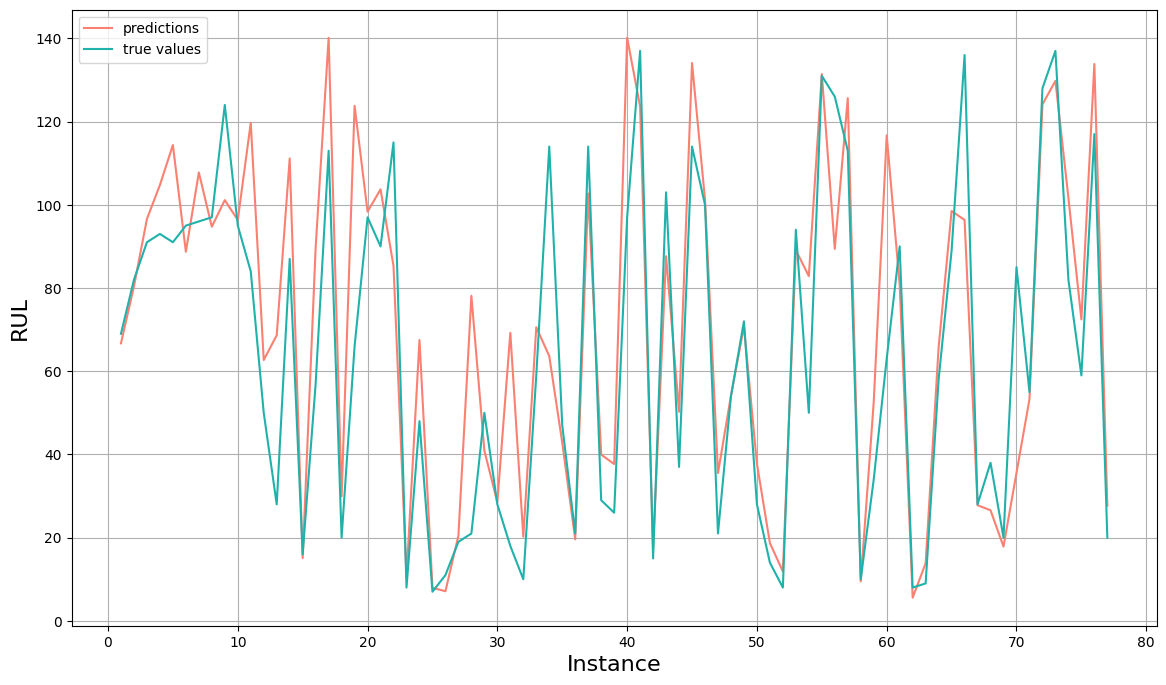

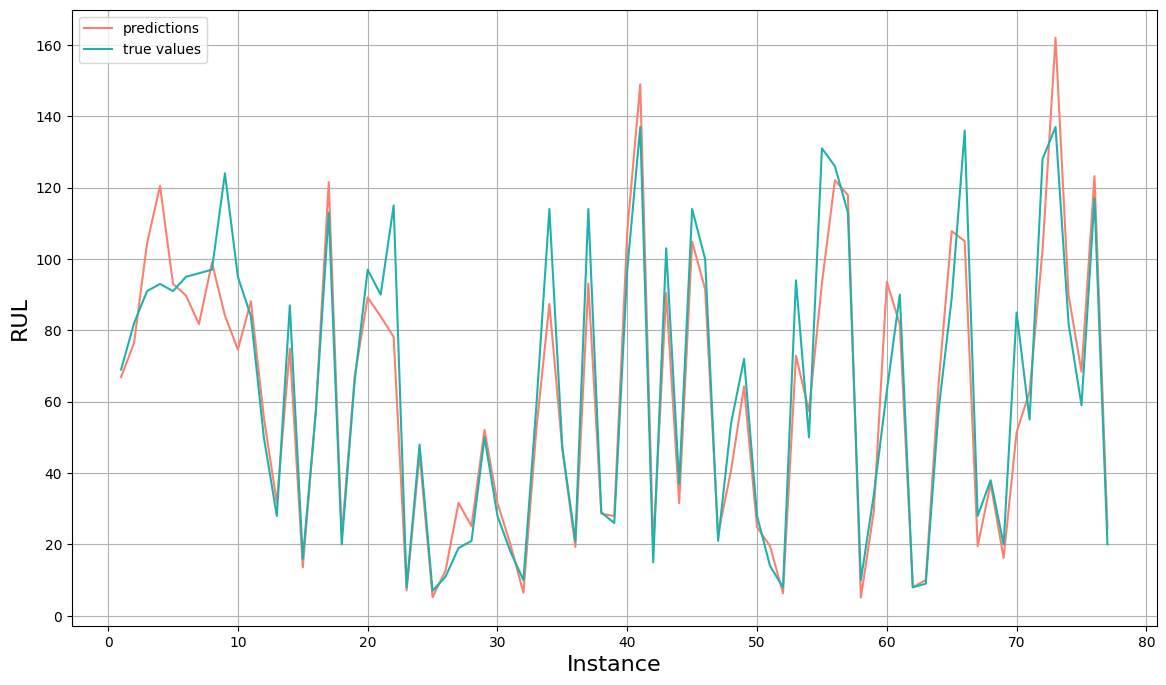

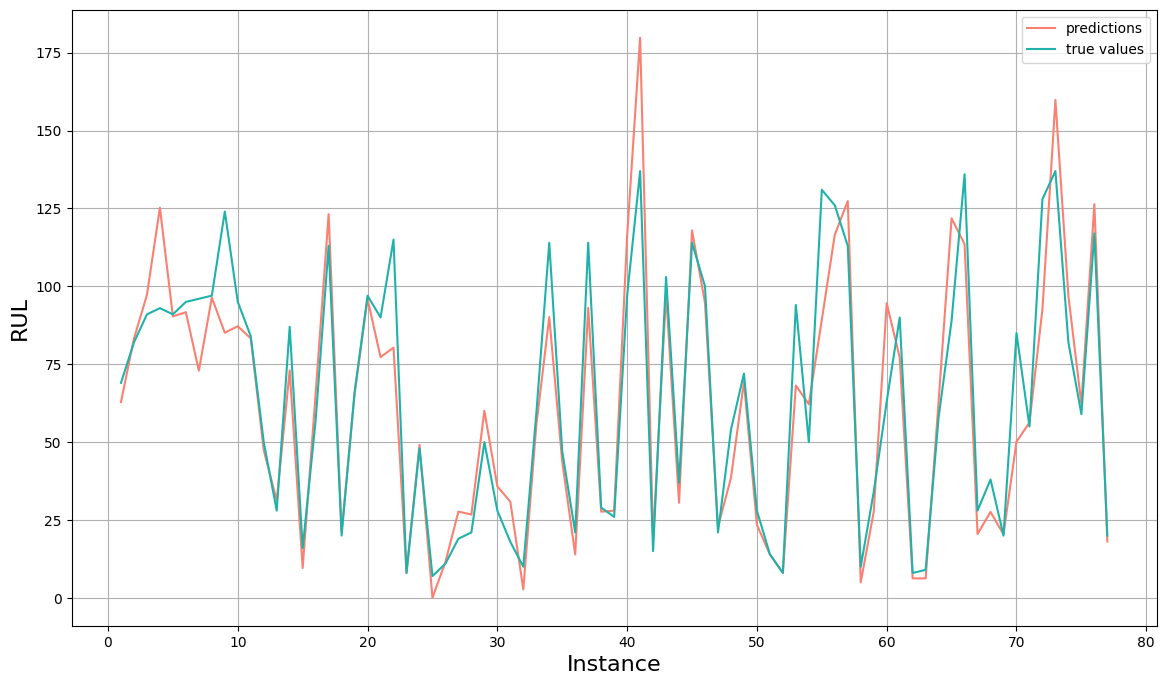

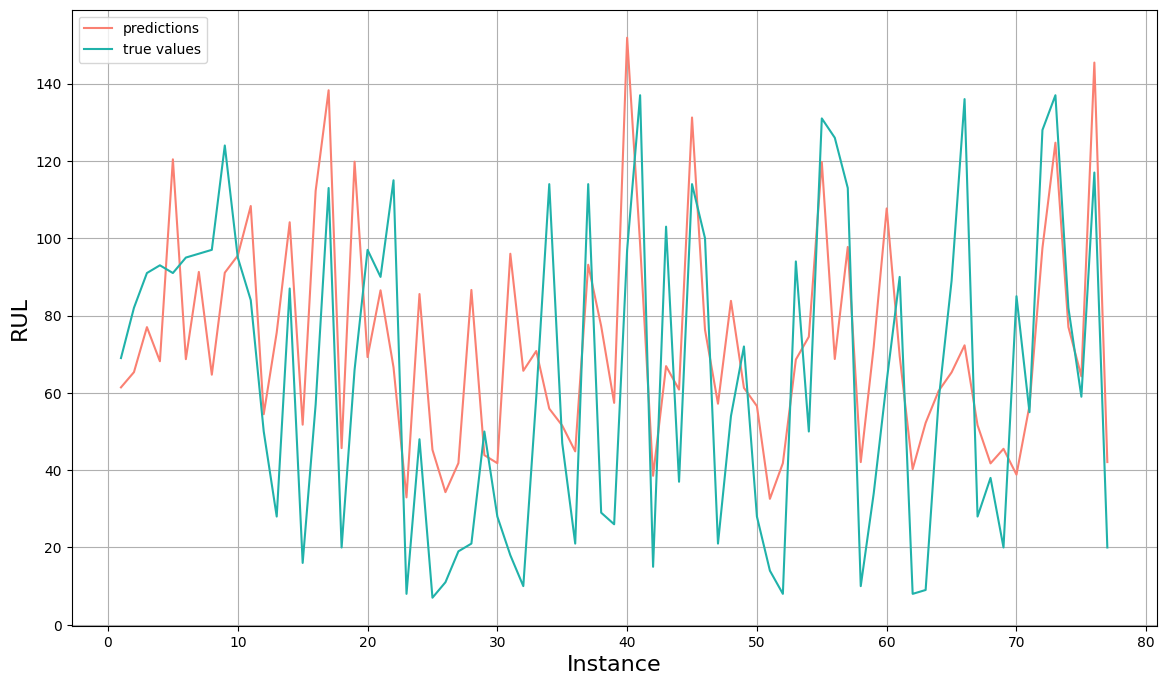

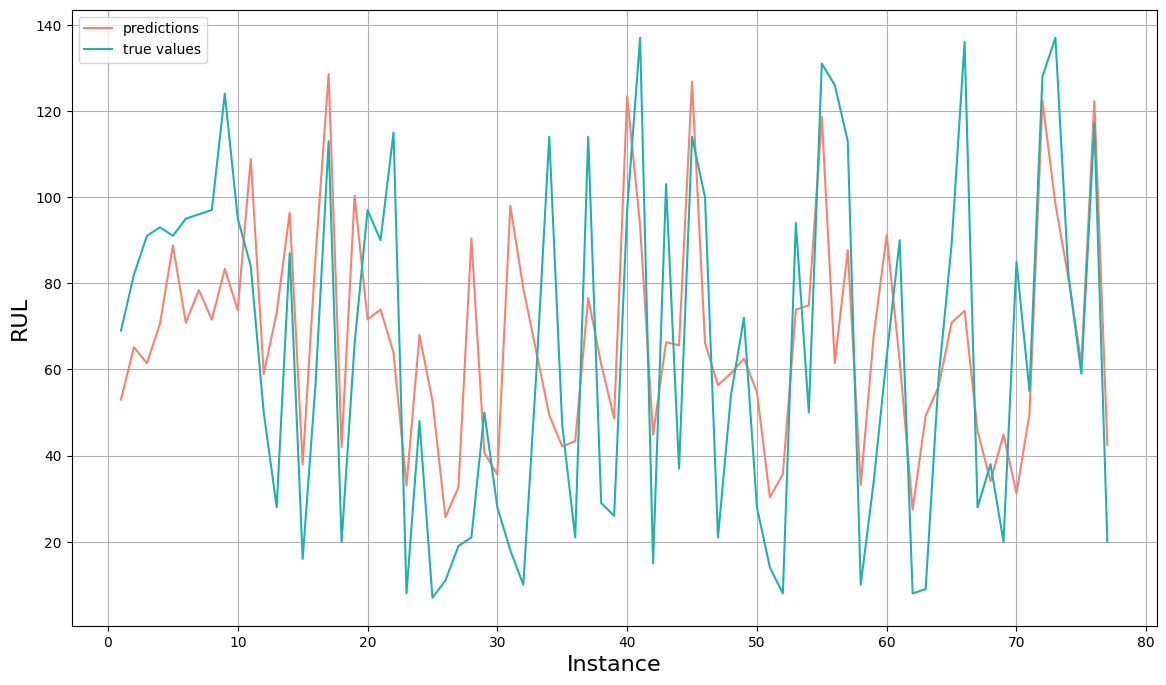

In [111]:
if DisplayGraph == 1:
    UtilsTool.DisplayGraph(y_pred_rnn, y, FiguresPath, "NormalRNNDetection")
    UtilsTool.DisplayGraph(y_pred_gru, y, FiguresPath, "NormalGRUDetection")
    UtilsTool.DisplayGraph(y_pred_lstm, y, FiguresPath, "NormalLSTMDetection")
    UtilsTool.DisplayGraph(y_pred_singlexp, y, FiguresPath, "NormalSingleExpDetection")
    UtilsTool.DisplayGraph(y_pred_exp, y, FiguresPath, "NormalExpDetection")

In [112]:
testloaderAttack = DataLoader(testloader.dataset, batch_size=100, shuffle=False)
X, y = next(iter(testloaderAttack))
X, y = X.to(device), y.to(device)

AttacksParameters = {
    "FGSM": {
        "Objective": 300,
        "Epsilon": 0.06
    },
    "BIM": {
        "Objective": 300,
        "Iterations": 120,
        "Epsilon": 0.001
    },
    "CW": {
        "Objective": 0,
        "Iterations": 1000,
        "LearningRate": 0.01,
        "c": 0.02,
    }
}

print("RNN")
RNNAdversarialDataFgsm, RNNAdversarialDataBim, RNNAdversarialDataCW = AttacksTool.TestAttacks(MyRNNModel, X, y, AttacksParameters, device)
print()

AttacksParameters = {
    "FGSM": {
        "Objective": 300,
        "Epsilon": 0.060
    },
    "BIM": {
        "Objective": 300,
        "Iterations": 65,
        "Epsilon": 0.001
    },
    "CW": {
        "Objective": 0,
        "Iterations": 1000,
        "LearningRate": 0.01,
        "c": 0.002,
    }
}

print("GRU")
GRUAdversarialDataFgsm, GRUAdversarialDataBim, GRUAdversarialDataCW = AttacksTool.TestAttacks(MyGRUModel, X, y, AttacksParameters, device)
print()

AttacksParameters = {
    "FGSM": {
        "Objective": 300,
        "Epsilon": 0.055
    },
    "BIM": {
        "Objective": 300,
        "Iterations": 90,
        "Epsilon": 0.001
    },
    "CW": {
        "Objective": 0,
        "Iterations": 1000,
        "LearningRate": 0.01,
        "c": 0.004,
    }
}

print("LSTM")
LSTMAdversarialDataFgsm, LSTMAdversarialDataBim, LSTMAdversarialDataCW = AttacksTool.TestAttacks(MyLSTMModel, X, y, AttacksParameters, device)

AttacksParameters = {
    "FGSM": {
        "Objective": 300,
        "Epsilon": 0.055
    },
    "BIM": {
        "Objective": 300,
        "Iterations": 50,
        "Epsilon": 0.001
    },
    "CW": {
        "Objective": 0,
        "Iterations": 1000,
        "LearningRate": 0.01,
        "c": 0.00001,
    }
}
print()
print("Single EXP")
SingleExpAdversarialDataFgsm, SingleExpAdversarialDataBim, SingleExpAdversarialDataCW = AttacksTool.TestAttacks(MySingleExpModel, X, y, AttacksParameters, device)

AttacksParameters = {
    "FGSM": {
        "Objective": 300,
        "Epsilon": 0.06
    },
    "BIM": {
        "Objective": 300,
        "Iterations": 60,
        "Epsilon": 0.001
    },
    "CW": {
        "Objective": 0,
        "Iterations": 1000,
        "LearningRate": 0.01,
        "c": 0.000004,
    }
}
print()
print("EXP")
ExpAdversarialDataFgsm, ExpAdversarialDataBim, ExpAdversarialDataCW = AttacksTool.TestAttacks(MyExpModel, X, y, AttacksParameters, device)

RNN
FGSM: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 41.668636322021484, 'RMSE_adversarial': 0.05490428954362869, 'RMSE_pred': 31.824527740478516, 'L0': tensor(24.)}
BIM: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 21.016260147094727, 'RMSE_adversarial': 0.051802560687065125, 'RMSE_pred': 51.003746032714844, 'L0': tensor(24.)}
CW: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 0.0031628403812646866, 'RMSE_adversarial': 0.04933729022741318, 'RMSE_pred': 75.99961853027344, 'L0': tensor(24.)}

GRU
FGSM: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 18.43494415283203, 'RMSE_adversarial': 0.054831214249134064, 'RMSE_pred': 57.1057014465332, 'L0': tensor(24.)}
BIM: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 2.5615804195404053, 'RMSE_adversarial': 0.05220765992999077, 'RMSE_pred': 72.80780792236328, 'L0': tensor(23.9351)}
CW: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 0.3970373868942261, 'RMSE_adversarial': 0.05328387

In [113]:
print("RNN")
PRNNAdversarialDataFgsm = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataFgsm, MyRNNModel, minmax_dict, window, device)
PRNNAdversarialDataBim = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataBim, MyRNNModel, minmax_dict, window, device)
PRNNAdversarialDataCW = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataCW, MyRNNModel, minmax_dict, window, device)

print("GRU")
PGRUAdversarialDataFgsm = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataFgsm, MyGRUModel, minmax_dict, window, device)
PGRUAdversarialDataBim = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataBim, MyGRUModel, minmax_dict, window, device)
PGRUAdversarialDataCW = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataCW, MyGRUModel, minmax_dict, window, device)

print("LSTM")
PLSTMAdversarialDataFgsm = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataFgsm, MyLSTMModel, minmax_dict, window, device)
PLSTMAdversarialDataBim = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataBim, MyLSTMModel, minmax_dict, window, device)
PLSTMAdversarialDataCW = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataCW, MyLSTMModel, minmax_dict, window, device)

print("Single EXP")
PSingleExpAdversarialDataFgsm = UtilsTool.TestProjectionCost(testloaderAttack, X, SingleExpAdversarialDataFgsm, MySingleExpModel, minmax_dict, window, device)
PSingleExpAdversarialDataBim = UtilsTool.TestProjectionCost(testloaderAttack, X, SingleExpAdversarialDataBim, MySingleExpModel, minmax_dict, window, device)
PSingleExpAdversarialDataCW = UtilsTool.TestProjectionCost(testloaderAttack, X, SingleExpAdversarialDataCW, MySingleExpModel, minmax_dict, window, device)

print("EXP")
PExpAdversarialDataFgsm = UtilsTool.TestProjectionCost(testloaderAttack, X, ExpAdversarialDataFgsm, MyExpModel, minmax_dict, window, device)
PExpAdversarialDataBim = UtilsTool.TestProjectionCost(testloaderAttack, X, ExpAdversarialDataBim, MyExpModel, minmax_dict, window, device)
PExpAdversarialDataCW = UtilsTool.TestProjectionCost(testloaderAttack, X, ExpAdversarialDataCW, MyExpModel, minmax_dict, window, device)

RNN
Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 41.668636322021484, 'RMSE_adversarial': 0.05490428954362869, 'RMSE_pred': 31.824527740478516, 'L0': tensor(24.)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 43.07719802856445, 'RMSE_adversarial': 0.05165189132094383, 'RMSE_pred': 30.74812889099121, 'L0': tensor(16.)}

Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 21.016260147094727, 'RMSE_adversarial': 0.051802560687065125, 'RMSE_pred': 51.003746032714844, 'L0': tensor(24.)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 23.815214157104492, 'RMSE_adversarial': 0.04548564553260803, 'RMSE_pred': 48.335350036621094, 'L0': tensor(16.)}

Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 0.0031628403812646866, 'RMSE_adversarial': 0.04933729022741318, 'RMSE_pred': 75.99961853027344, 'L0': tensor(24.)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 1.9371377229690552, 'RMSE_adv

In [114]:
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataFgsm, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/FGSM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataBim, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/BIM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataCW, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/CW", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataFgsm, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/FGSM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataBim, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/BIM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataCW, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/CW", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataFgsm, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/FGSM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataBim, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/BIM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataCW, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/CW", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataFgsm, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/SingleEXP", AdversarialOutputPath + "/SingleEXP" + "/FGSM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataBim, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/SingleEXP", AdversarialOutputPath + "/SingleEXP" + "/BIM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataCW, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/SingleEXP", AdversarialOutputPath + "/SingleEXP" + "/CW", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataFgsm, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/EXP", AdversarialOutputPath + "/EXP" + "/FGSM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataBim, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/EXP", AdversarialOutputPath + "/EXP" + "/BIM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataCW, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/EXP", AdversarialOutputPath + "/EXP" + "/CW", device)

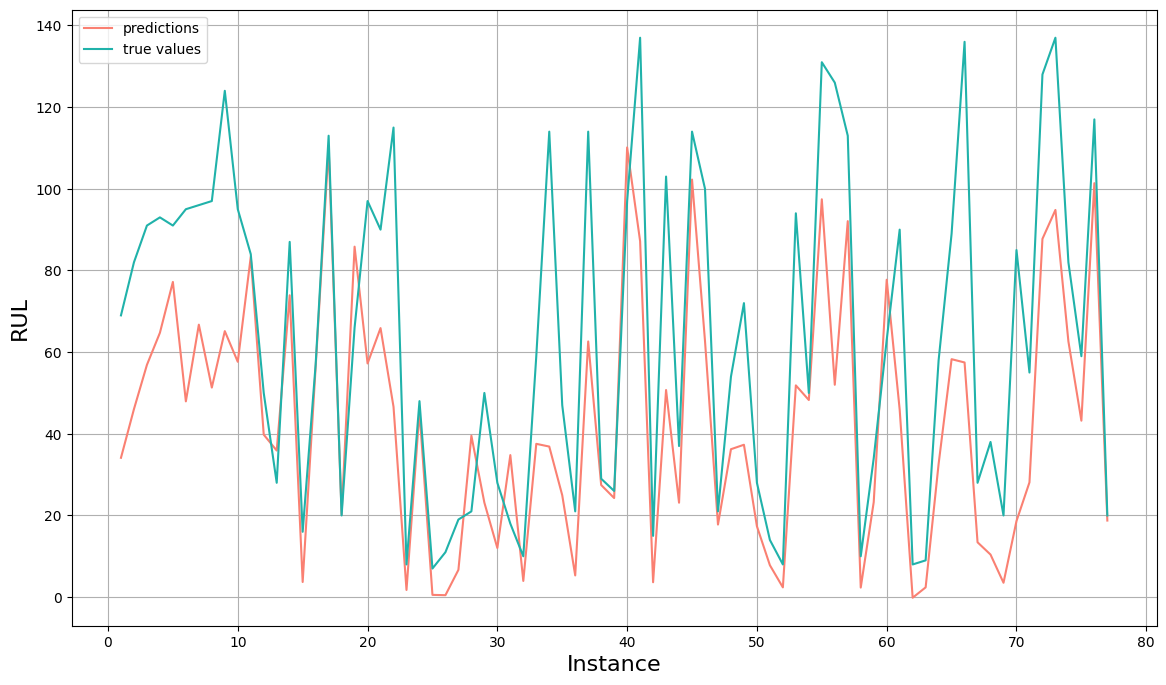

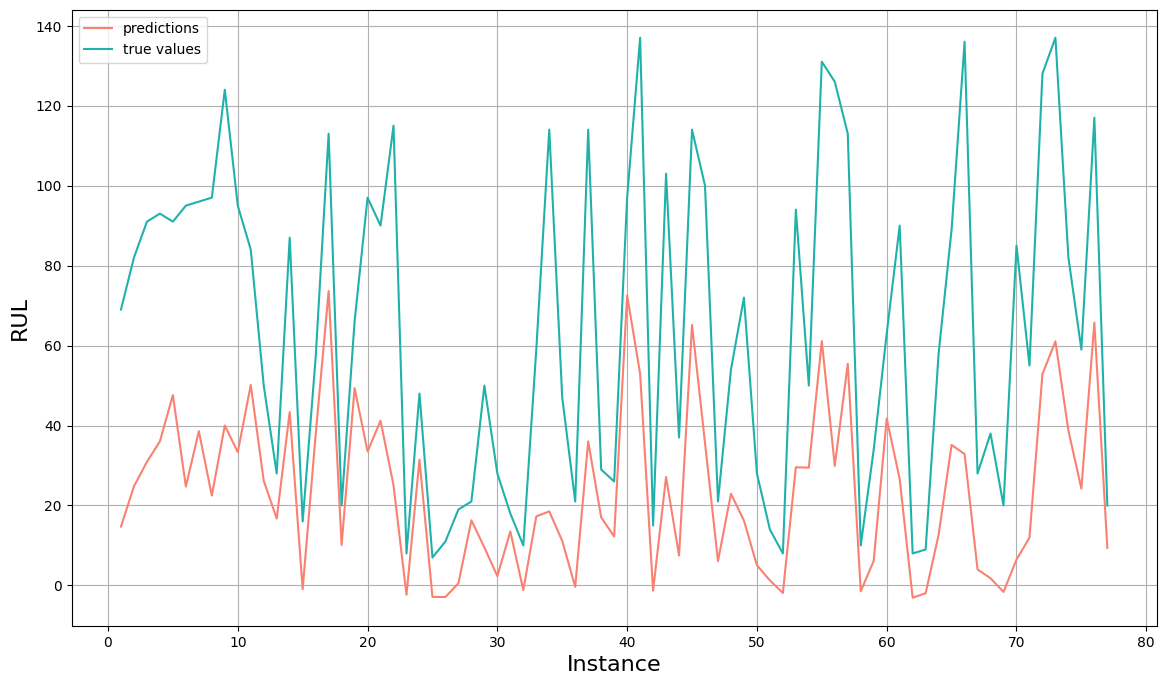

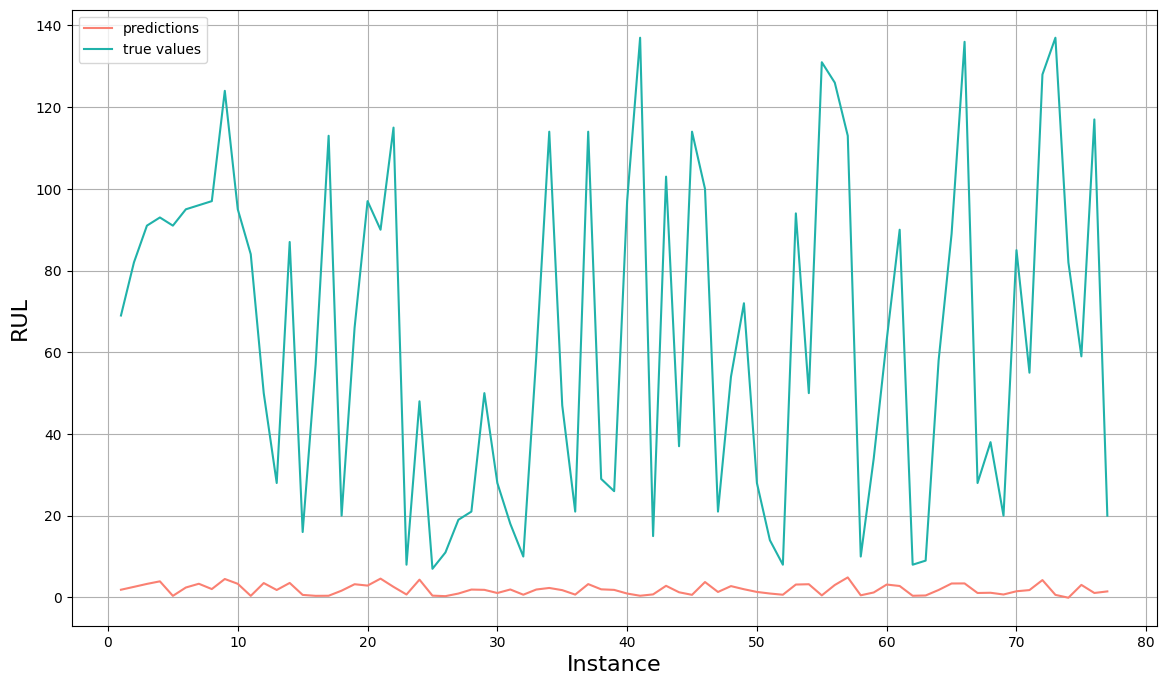

In [115]:
if DisplayGraph == 1:
    y_pred = MyRNNModel(PRNNAdversarialDataFgsm)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "FGSMRNNDetection")
    y_pred = MyRNNModel(PRNNAdversarialDataBim)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "BIMRNNDetection")
    y_pred = MyRNNModel(PRNNAdversarialDataCW)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "CWRNNDetection")

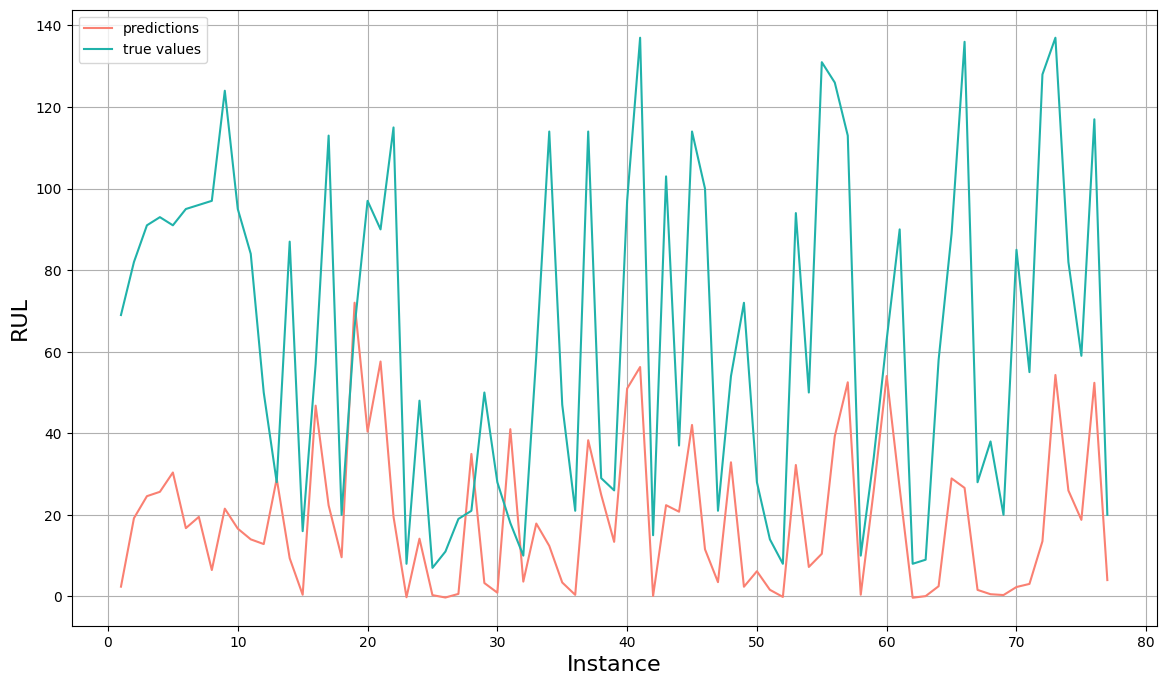

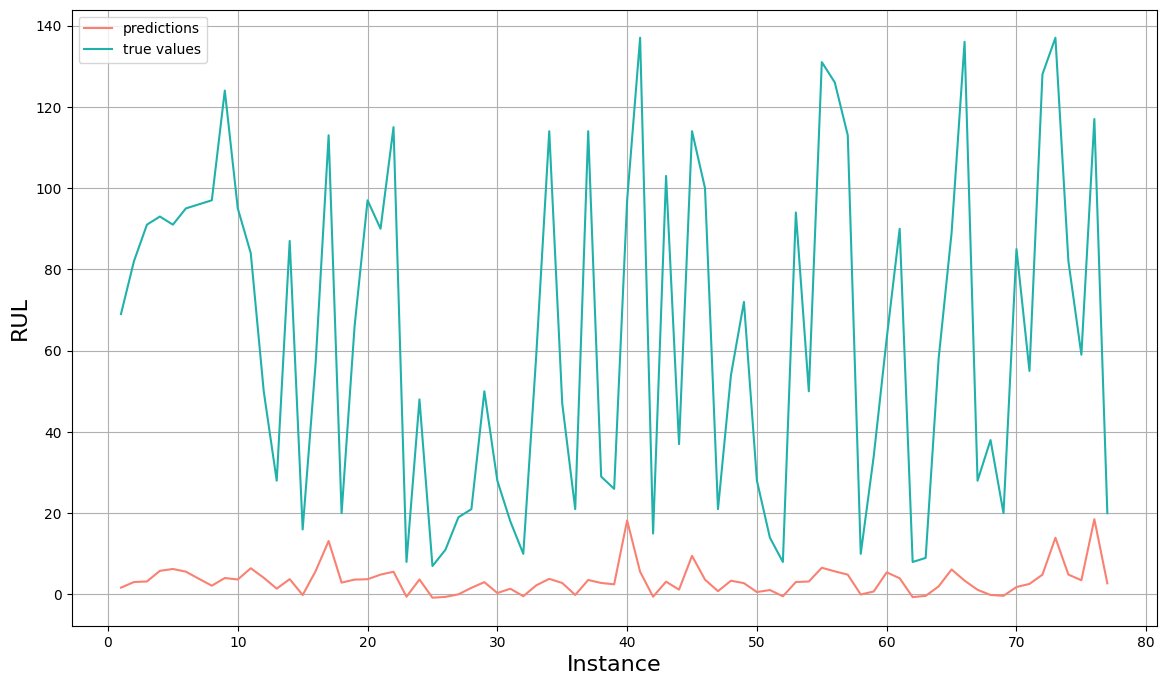

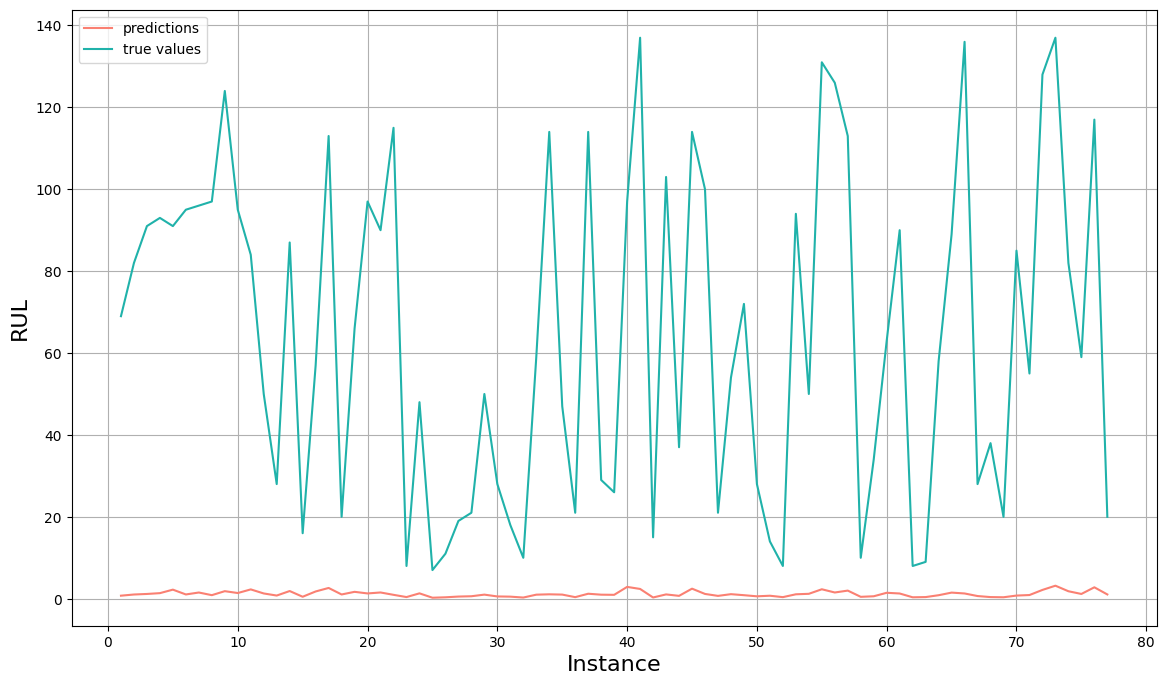

In [116]:
if DisplayGraph == 1:
    y_pred = MyGRUModel(PGRUAdversarialDataFgsm)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "FGSMGRUDetection")
    y_pred = MyGRUModel(PGRUAdversarialDataBim)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "BIMGRUDetection")
    y_pred = MyGRUModel(PGRUAdversarialDataCW)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "CWGRUDetection")

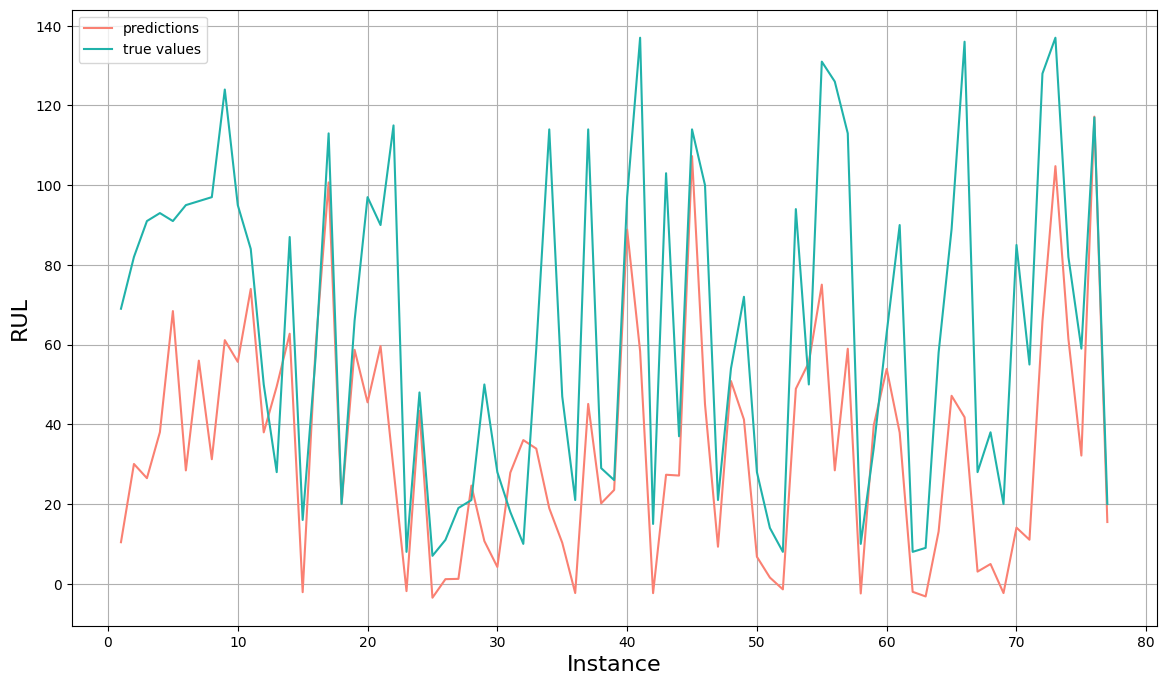

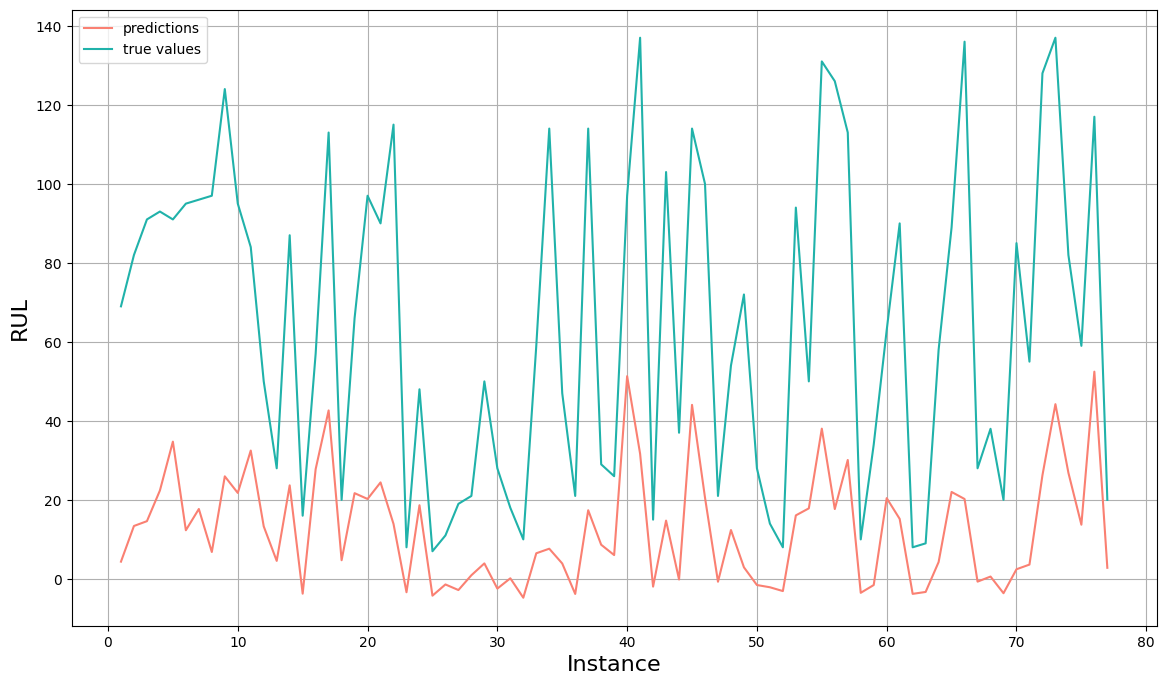

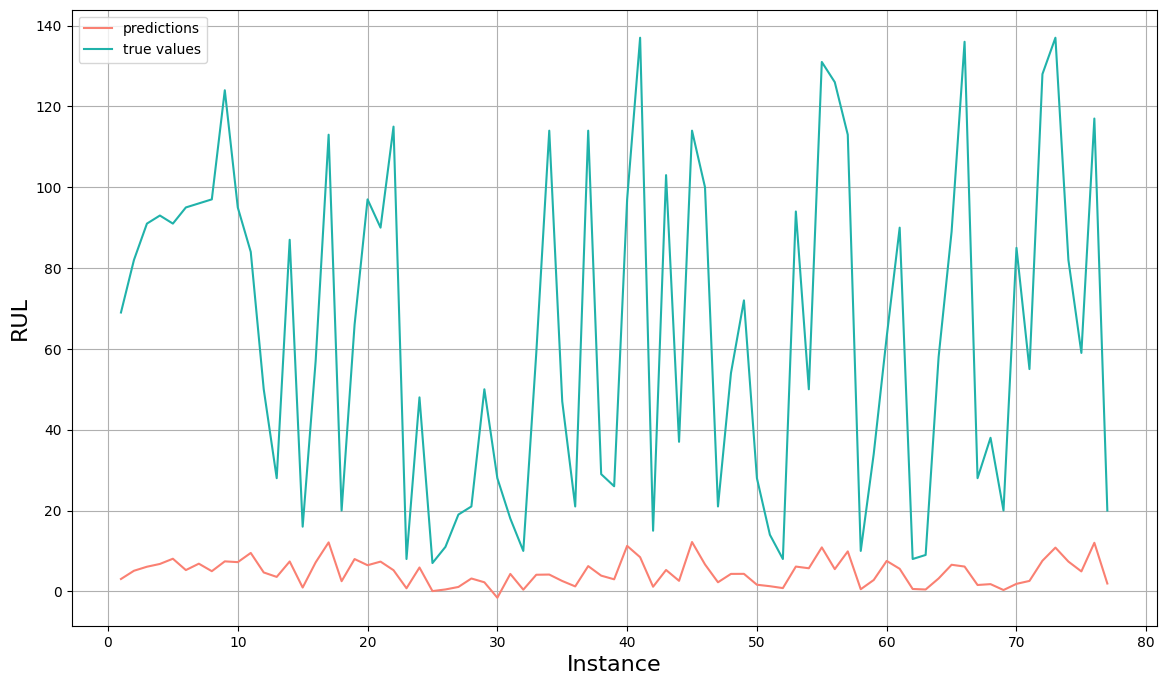

In [117]:
if DisplayGraph == 1:
    y_pred = MyLSTMModel(PLSTMAdversarialDataFgsm)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "FGSMLSTMDetection")
    y_pred = MyLSTMModel(PLSTMAdversarialDataBim)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "BIMLSTMDetection")
    y_pred = MyLSTMModel(PLSTMAdversarialDataCW)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "CWLSTMDetection")

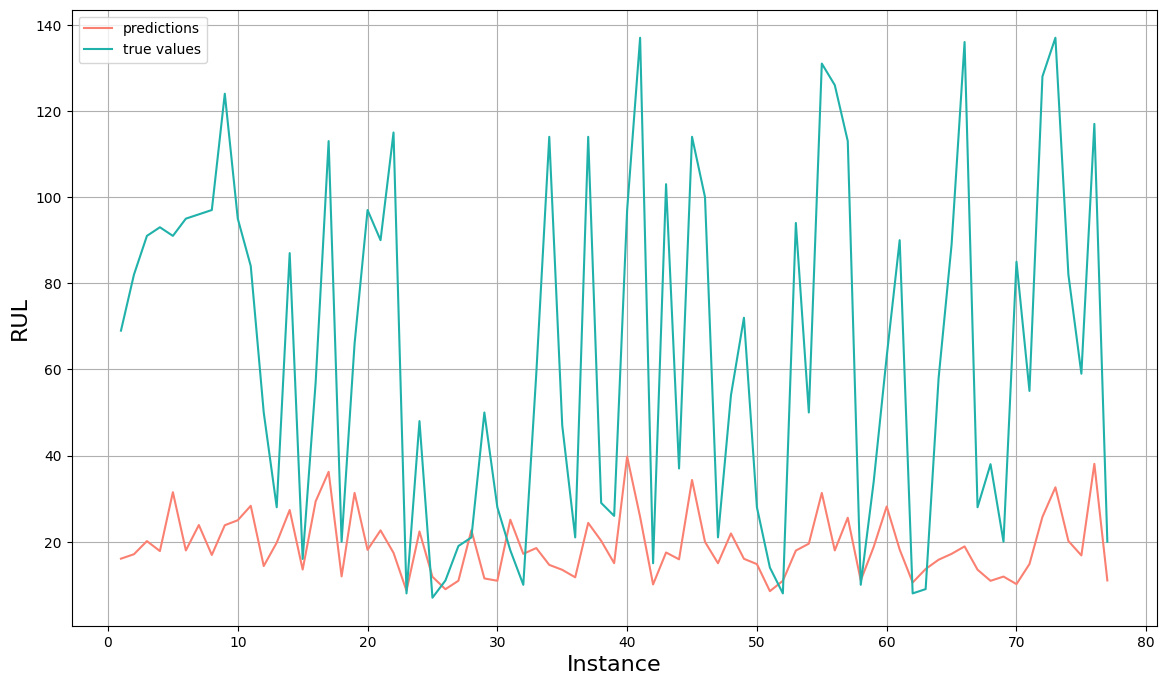

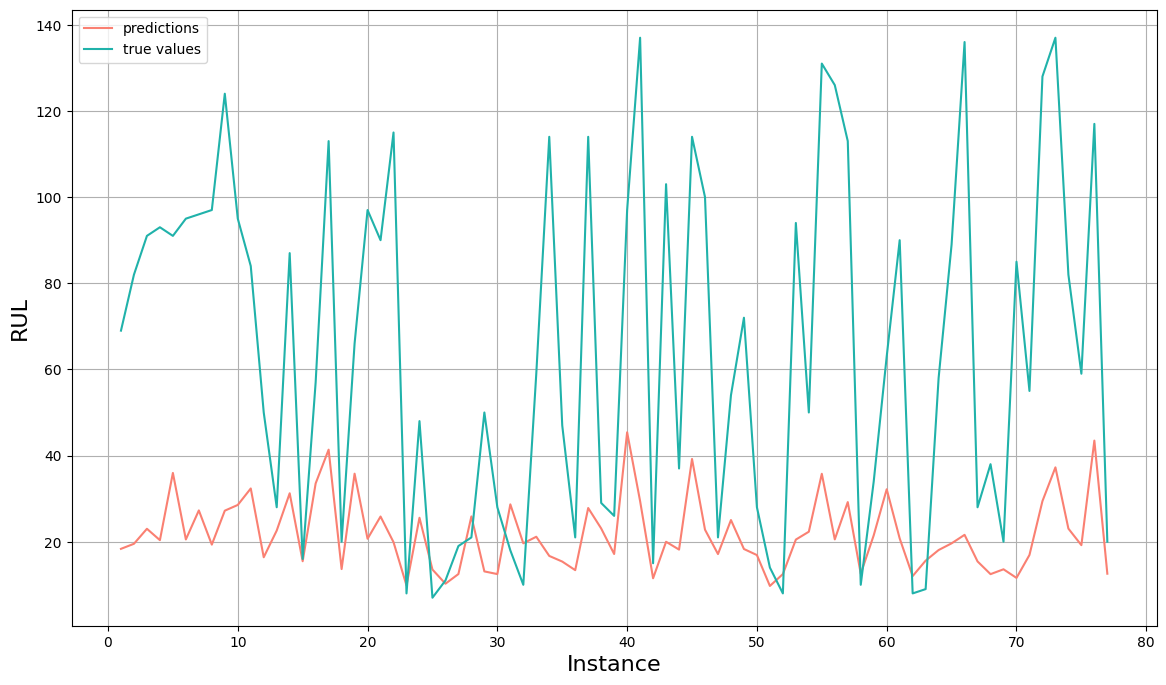

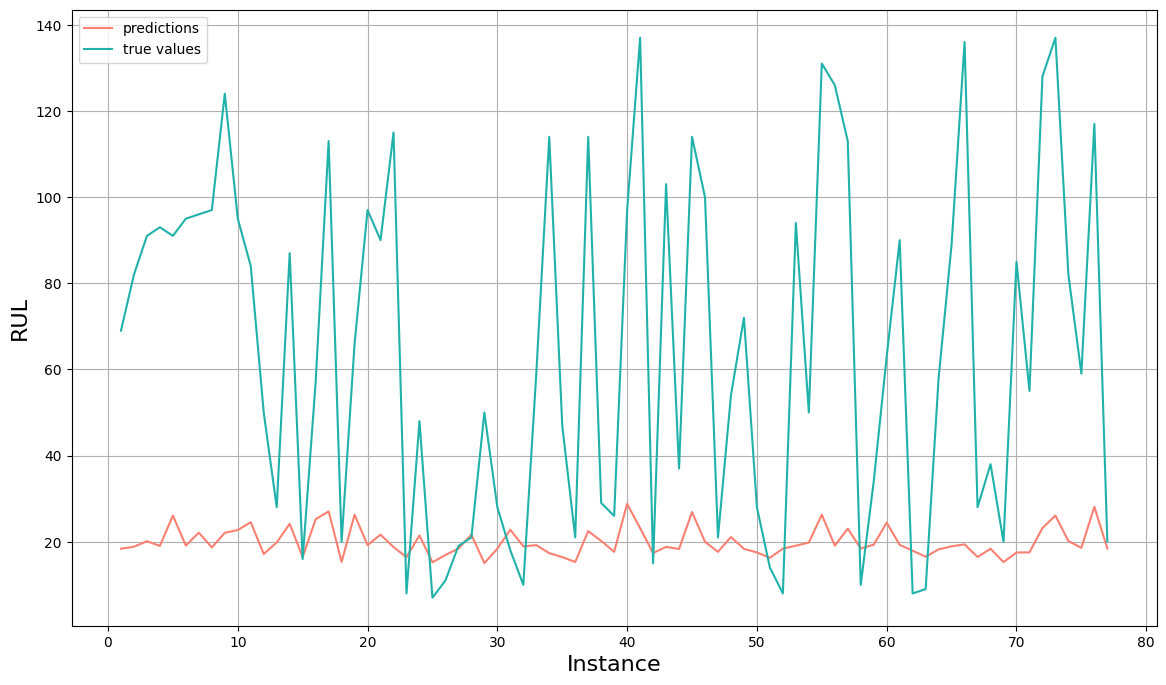

In [118]:
if DisplayGraph == 1:
    y_pred = MySingleExpModel(PSingleExpAdversarialDataFgsm)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "FGSMLSTMDetection")
    y_pred = MySingleExpModel(PSingleExpAdversarialDataBim)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "BIMLSTMDetection")
    y_pred = MySingleExpModel(PSingleExpAdversarialDataCW)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "CWLSTMDetection")

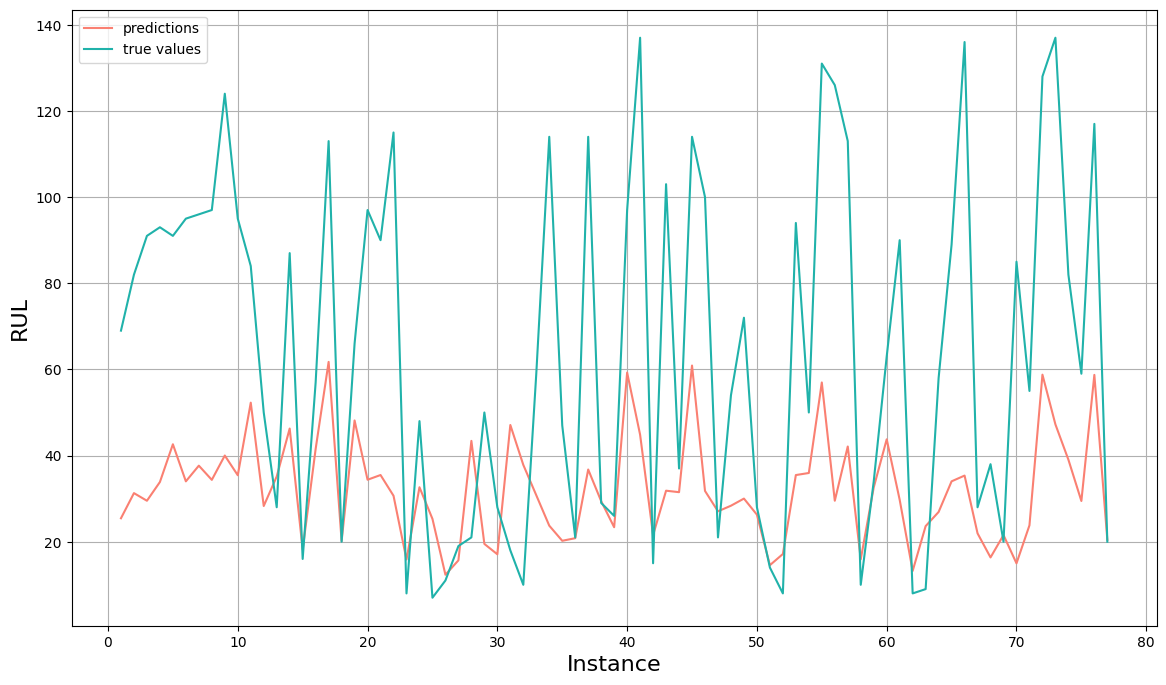

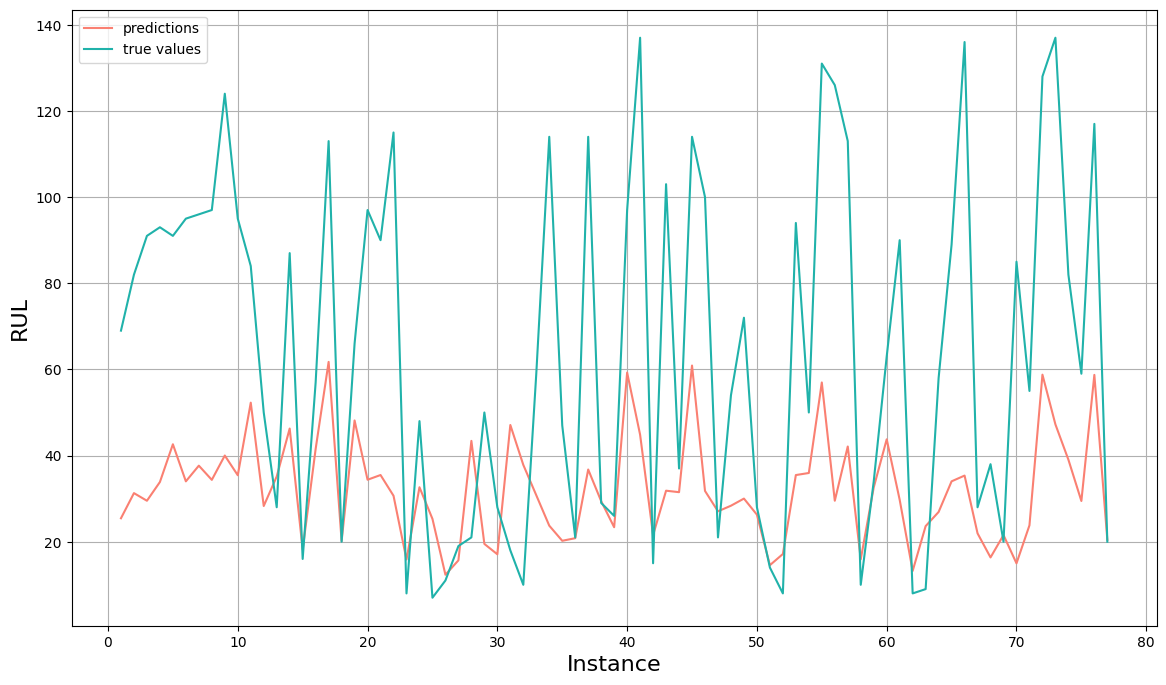

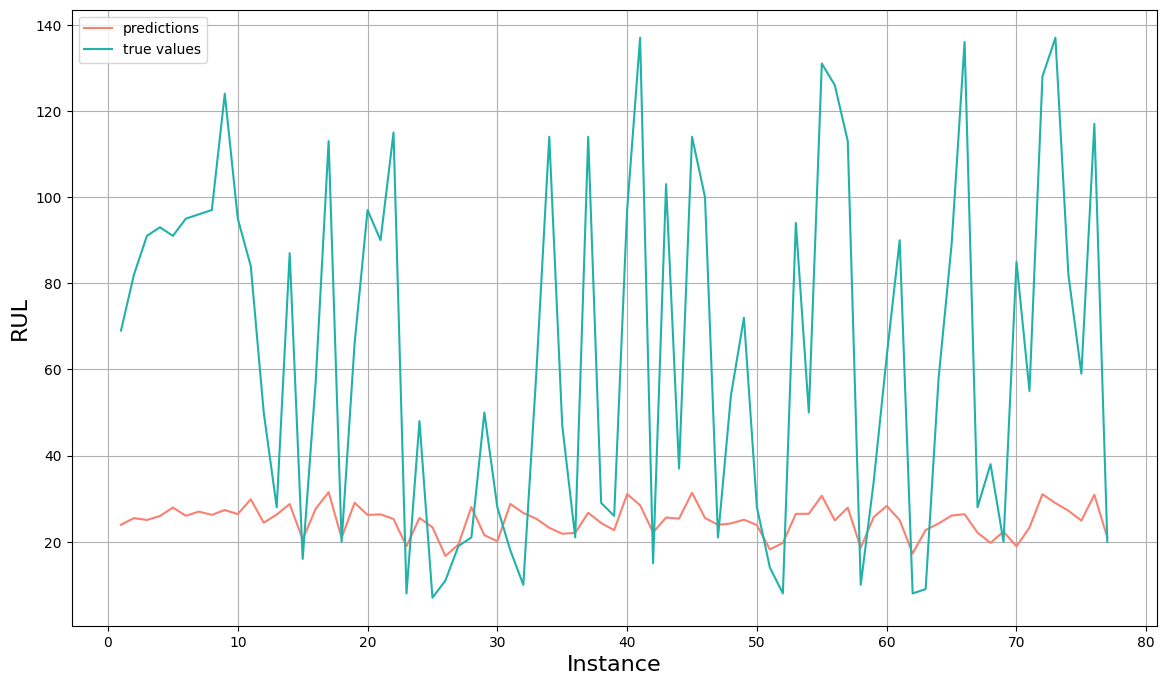

In [119]:
if DisplayGraph == 1:
    y_pred = MyExpModel(PExpAdversarialDataFgsm)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "FGSMLSTMDetection")
    y_pred = MyExpModel(PExpAdversarialDataBim)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "BIMLSTMDetection")
    y_pred = MyExpModel(PExpAdversarialDataCW)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "CWLSTMDetection")

In [120]:
if OptimizeParameters == 1:
    AttacksTool.OptimizeParameters(X, y, MyRNNModel, OptimalParametersPath, 2, "RNN", device)
    AttacksTool.OptimizeParameters(X, y, MyGRUModel, OptimalParametersPath, 2, "GRU", device)
    AttacksTool.OptimizeParameters(X, y, MyLSTMModel, OptimalParametersPath, 2, "LSTM", device)
    AttacksTool.OptimizeParameters(X, y, MySingleExpModel, OptimalParametersPath, 15, "SingleExp", device)
    AttacksTool.OptimizeParameters(X, y, MyExpModel, OptimalParametersPath, 1, "Exp", device)

In [121]:
if DisplayGraph == 1 and OptimizeParameters == 1:
    UtilsTool.AnalyzeK(20, OptimalParametersPath + "OptimizeKSingleExp.txt", OptimalParametersPath)   
    UtilsTool.AnalyzePS(20, OptimalParametersPath + "OptimizePSSingleExp.txt", OptimalParametersPath)   

In [122]:

if DisplayGraph == 1 and OptimizeParameters == 1:
    AttacksParametersMaillard = {
        "Maillard": {
            "Objective": 0,
            "Iterations": 1000,
            "LearningRate": 0.01,
            "Initial_c": 1,
            "Final_c": 0.001,
            "Steps_c":2,
            "k": 2,
            "P": 8,
            "S": 0.1
        }
    }
    AttacksTool.TestNewAttacks(MyRNNModel, X, y, AttacksParametersMaillard, device, FiguresPath, "NewAttackRNN_C_")

    AttacksParametersMaillard = {
        "Maillard": {
            "Objective": 0,
            "Iterations": 1000,
            "LearningRate": 0.01,
            "Initial_c": 1,
            "Final_c": 0.001,
            "Steps_c":2,
            "k": 2,
            "P": 8,
            "S": 0.1

        }
    }
    AttacksTool.TestNewAttacks(MyGRUModel, X, y, AttacksParametersMaillard, device, FiguresPath, "NewAttackGRU_C_")

    AttacksParametersMaillard = {
        "Maillard": {
            "Objective": 0,
            "Iterations": 1000,
            "LearningRate": 0.01,
            "Initial_c": 1,
            "Final_c": 0.001,
            "Steps_c":2,
            "k": 2,
            "P": 8,
            "S": 0.3

        }
    }
    AttacksTool.TestNewAttacks(MyLSTMModel, X, y, AttacksParametersMaillard, device, FiguresPath, "NewAttackLSTM_C_")

    AttacksParametersMaillard = {
        "Maillard": {
            "Objective": 0,
            "Iterations": 1000,
            "LearningRate": 0.01,
            "Initial_c": 1,
            "Final_c": 0.0001,
            "Steps_c":2,
            "k": 15,
            "P": 3,
            "S": 0.1

        }
    }
    AttacksTool.TestNewAttacks(MySingleExpModel, X, y, AttacksParametersMaillard, device, FiguresPath, "NewAttackSingleExp_C_")


    AttacksParametersMaillard = {
        "Maillard": {
            "Objective": 0,
            "Iterations": 1000,
            "LearningRate": 0.01,
            "Initial_c": 1,
            "Final_c": 0.0001,
            "Steps_c":2,
            "k": 1,
            "P": 3,
            "S": 0.3

        }
    }
    AttacksTool.TestNewAttacks(MyExpModel, X, y, AttacksParametersMaillard, device, FiguresPath, "NewAttackExp_C_") 

In [123]:
RNNAdversarialDataMaillardL2 = AttacksTool.MaillardL2(MyRNNModel, 0, X.float(), y.float(), 0.01, 1, 1000, device)
Infos = UtilsTool.GetInfos(X, y, 0, RNNAdversarialDataMaillardL2, MyRNNModel)
print("Maillard-L2:", Infos)

GRUAdversarialDataMaillardL2 = AttacksTool.MaillardL2(MyGRUModel, 0, X.float(), y.float(), 0.01, 1, 1000, device)
Infos = UtilsTool.GetInfos(X, y, 0, GRUAdversarialDataMaillardL2, MyGRUModel)
print("Maillard-L2:", Infos)

LSTMAdversarialDataMaillardL2 = AttacksTool.MaillardL2(MyLSTMModel, 0, X.float(), y.float(), 0.01, 1, 1000, device)
Infos = UtilsTool.GetInfos(X, y, 0, LSTMAdversarialDataMaillardL2, MyLSTMModel)
print("Maillard-L2:", Infos)

SingleExpAdversarialDataMaillardL2 = AttacksTool.MaillardL2(MySingleExpModel, 0, X.float(), y.float(), 0.01, 1, 1000, device)
Infos = UtilsTool.GetInfos(X, y, 0, SingleExpAdversarialDataMaillardL2, MySingleExpModel)
print("Maillard-L2:", Infos)

ExpAdversarialDataMaillardL2 = AttacksTool.MaillardL2(MyExpModel, 0, X.float(), y.float(), 0.01, 1, 1000, device)
Infos = UtilsTool.GetInfos(X, y, 0, ExpAdversarialDataMaillardL2, MyExpModel)
print("Maillard-L2:", Infos)

Maillard-L2: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 3.246049642562866, 'RMSE_adversarial': 0.02930368110537529, 'RMSE_pred': 72.78682708740234, 'L0': tensor(23.8442)}
Maillard-L2: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 4.1624932289123535, 'RMSE_adversarial': 0.021223703399300575, 'RMSE_pred': 72.27922821044922, 'L0': tensor(24.)}
Maillard-L2: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 3.2048587799072266, 'RMSE_adversarial': 0.02967594750225544, 'RMSE_pred': 72.72103881835938, 'L0': tensor(23.8182)}
Maillard-L2: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 14.349274635314941, 'RMSE_adversarial': 0.04755895584821701, 'RMSE_pred': 63.73972702026367, 'L0': tensor(23.4026)}
Maillard-L2: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 20.335905075073242, 'RMSE_adversarial': 0.0578029602766037, 'RMSE_pred': 58.5630989074707, 'L0': tensor(17.)}


In [124]:
RNNAdversarialDataMaillardL0 = AttacksTool.MaillardL0(MyRNNModel, 0, X.float(), y.float(), 0.01, 0.01, 1000, 2, 8, 0.1, device)
Infos = UtilsTool.GetInfos(X, y, 0, RNNAdversarialDataMaillardL0, MyRNNModel)
print("Maillard-L0:", Infos)

GRUAdversarialDataMaillardL0 = AttacksTool.MaillardL0(MyGRUModel, 0, X.float(), y.float(), 0.01, 0.01, 1000, 2, 8, 0.1, device)
Infos = UtilsTool.GetInfos(X, y, 0, GRUAdversarialDataMaillardL0, MyGRUModel)
print("Maillard-L0:", Infos)

LSTMAdversarialDataMaillardL0 = AttacksTool.MaillardL0(MyLSTMModel, 0, X.float(), y.float(), 0.01, 0.01, 1000, 2, 8, 0.3, device)
Infos = UtilsTool.GetInfos(X, y, 0, LSTMAdversarialDataMaillardL0, MyLSTMModel)
print("Maillard-L0:", Infos)

SingleExpAdversarialDataMaillardL0 = AttacksTool.MaillardL0(MySingleExpModel, 0, X.float(), y.float(), 0.01, 0.002, 1000, 15, 5, 0.3, device)
Infos = UtilsTool.GetInfos(X, y, 0, SingleExpAdversarialDataMaillardL0, MySingleExpModel)
print("Maillard-L0:", Infos)

ExpAdversarialDataMaillardL0 = AttacksTool.MaillardL0(MyExpModel, 0, X.float(), y.float(), 0.01, 0.001, 1000, 1, 3, 0.3, device)
Infos = UtilsTool.GetInfos(X, y, 0, ExpAdversarialDataMaillardL0, MyExpModel)
print("Maillard-L0:", Infos)

Maillard-L0: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 6.232931137084961, 'RMSE_adversarial': 0.06714972108602524, 'RMSE_pred': 71.76761627197266, 'L0': tensor(4.6494)}
Maillard-L0: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 4.2202582359313965, 'RMSE_adversarial': 0.04812851548194885, 'RMSE_pred': 72.92314147949219, 'L0': tensor(1.8052)}
Maillard-L0: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 4.913753032684326, 'RMSE_adversarial': 0.07734573632478714, 'RMSE_pred': 73.30583953857422, 'L0': tensor(2.3377)}
Maillard-L0: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 38.245365142822266, 'RMSE_adversarial': 0.08391758054494858, 'RMSE_pred': 57.9505729675293, 'L0': tensor(7.7532)}
Maillard-L0: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 25.608407974243164, 'RMSE_adversarial': 0.1372678428888321, 'RMSE_pred': 62.91518020629883, 'L0': tensor(1.0519)}


In [125]:
print("RNN")
PRNNAdversarialDataMaillardL2 = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataMaillardL2, MyRNNModel, minmax_dict, window, device)
PRNNAdversarialDataMaillardL0 = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataMaillardL0, MyRNNModel, minmax_dict, window, device)
print("GRU")
PGRUAdversarialDataMaillardL2 = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataMaillardL2, MyGRUModel, minmax_dict, window, device)
PGRUAdversarialDataMaillardL0 = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataMaillardL0, MyGRUModel, minmax_dict, window, device)
print("LSTM")
PLSTMAdversarialDataMaillardL2 = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataMaillardL2, MyLSTMModel, minmax_dict, window, device)
PLSTMAdversarialDataMaillardL0 = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataMaillardL0, MyLSTMModel, minmax_dict, window, device)
print("Single EXP")
PSingleExpAdversarialDataMaillardL2 = UtilsTool.TestProjectionCost(testloaderAttack, X, SingleExpAdversarialDataMaillardL2, MyLSTMModel, minmax_dict, window, device)
PSingleExpAdversarialDataMaillardL0 = UtilsTool.TestProjectionCost(testloaderAttack, X, SingleExpAdversarialDataMaillardL0, MyLSTMModel, minmax_dict, window, device)
print("EXP")
PExpAdversarialDataMaillardL2 = UtilsTool.TestProjectionCost(testloaderAttack, X, ExpAdversarialDataMaillardL2, MyLSTMModel, minmax_dict, window, device)
PExpAdversarialDataMaillardL0 = UtilsTool.TestProjectionCost(testloaderAttack, X, ExpAdversarialDataMaillardL0, MyLSTMModel, minmax_dict, window, device)

RNN
Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 3.246049642562866, 'RMSE_adversarial': 0.02930368110537529, 'RMSE_pred': 72.78682708740234, 'L0': tensor(23.8442)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 4.4462690353393555, 'RMSE_adversarial': 0.028818128630518913, 'RMSE_pred': 71.56489562988281, 'L0': tensor(14.7403)}

Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 6.232931137084961, 'RMSE_adversarial': 0.06714972108602524, 'RMSE_pred': 71.76761627197266, 'L0': tensor(4.6494)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 6.236076354980469, 'RMSE_adversarial': 0.06714454293251038, 'RMSE_pred': 71.76383209228516, 'L0': tensor(4.6494)}

GRU
Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 4.1624932289123535, 'RMSE_adversarial': 0.021223703399300575, 'RMSE_pred': 72.27922821044922, 'L0': tensor(24.)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 5.511565685272217,

In [126]:
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataMaillardL2, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/L2", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataMaillardL0, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/L0", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataMaillardL2, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/L2", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataMaillardL0, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/L0", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataMaillardL2, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/L2", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataMaillardL0, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/L0", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataMaillardL2, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/SingleEXP", AdversarialOutputPath + "/SingleEXP" + "/L2", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataMaillardL0, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/SingleEXP", AdversarialOutputPath + "/SingleEXP" + "/L0", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataMaillardL2, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/EXP", AdversarialOutputPath + "/EXP" + "/L2", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataMaillardL0, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/EXP", AdversarialOutputPath + "/EXP" + "/L0", device)

In [127]:
print("Transferability RNN")
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataFgsm, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataBim, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataCW, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL0, MyRNNModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataFgsm, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataBim, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataCW, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL0, MyRNNModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataFgsm, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataBim, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataCW, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, MyRNNModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataFgsm, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataBim, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataCW, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL0, MyRNNModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataFgsm, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataBim, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataCW, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL0, MyRNNModel)
print(Infos)

Transferability RNN
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 43.07719802856445, 'RMSE_adversarial': 0.05165189132094383, 'RMSE_pred': 30.74812889099121, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 23.815214157104492, 'RMSE_adversarial': 0.04548564553260803, 'RMSE_pred': 48.335350036621094, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 1.9371377229690552, 'RMSE_adversarial': 0.045177850872278214, 'RMSE_pred': 74.07440948486328, 'L0': tensor(16.0649)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 4.4462690353393555, 'RMSE_adversarial': 0.028818128630518913, 'RMSE_pred': 71.56489562988281, 'L0': tensor(14.7403)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 6.236076354980469, 'RMSE_adversarial': 0.06714454293251038, 'RMSE_pred': 71.76383209228516, 'L0': tensor(4.6494)}

{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 43.167396545410156, 'RMSE_adversarial': 0.051650188863277435, 'RM

In [128]:
print("Transferability GRU")
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataFgsm, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataBim, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataCW, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL2, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL0, MyGRUModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataFgsm, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataBim, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataCW, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL2, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL0, MyGRUModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataFgsm, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataBim, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataCW, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, MyGRUModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataFgsm, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataBim, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataCW, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL2, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL0, MyGRUModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataFgsm, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataBim, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataCW, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL2, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL0, MyGRUModel)
print(Infos)

Transferability GRU
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 51.27300262451172, 'RMSE_adversarial': 0.05165189132094383, 'RMSE_pred': 25.024293899536133, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 21.460615158081055, 'RMSE_adversarial': 0.04548564553260803, 'RMSE_pred': 50.142967224121094, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 10.10074234008789, 'RMSE_adversarial': 0.045177850872278214, 'RMSE_pred': 65.99554443359375, 'L0': tensor(16.0649)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 18.66899299621582, 'RMSE_adversarial': 0.028818128630518913, 'RMSE_pred': 57.11671829223633, 'L0': tensor(14.7403)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 9.09874153137207, 'RMSE_adversarial': 0.06714454293251038, 'RMSE_pred': 69.57840728759766, 'L0': tensor(4.6494)}

{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 18.954708099365234, 'RMSE_adversarial': 0.051650188863277435, 'RMSE

In [129]:
print("Transferability LSTM")

Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataFgsm, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataBim, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataCW, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL2, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL0, MyLSTMModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataFgsm, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataBim, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataCW, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL2, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL0, MyLSTMModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataFgsm, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataBim, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataCW, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, MyLSTMModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataFgsm, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataBim, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataCW, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL2, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL0, MyLSTMModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataFgsm, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataBim, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataCW, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL2, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL0, MyLSTMModel)
print(Infos)

Transferability LSTM
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 50.10506820678711, 'RMSE_adversarial': 0.05165189132094383, 'RMSE_pred': 23.947824478149414, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 27.471277236938477, 'RMSE_adversarial': 0.04548564553260803, 'RMSE_pred': 46.09392166137695, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 19.62442970275879, 'RMSE_adversarial': 0.045177850872278214, 'RMSE_pred': 52.4698371887207, 'L0': tensor(16.0649)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 27.16221809387207, 'RMSE_adversarial': 0.028818128630518913, 'RMSE_pred': 44.92425537109375, 'L0': tensor(14.7403)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 16.657468795776367, 'RMSE_adversarial': 0.06714454293251038, 'RMSE_pred': 58.4961051940918, 'L0': tensor(4.6494)}

{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 43.0158805847168, 'RMSE_adversarial': 0.051650188863277435, 'RMSE_p

In [130]:
print("Transferability Single EXP")

Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataFgsm, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataBim, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataCW, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL2, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL0, MySingleExpModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataFgsm, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataBim, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataCW, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL2, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL0, MySingleExpModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataFgsm, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataBim, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataCW, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, MySingleExpModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataFgsm, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataBim, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataCW, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL2, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL0, MySingleExpModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataFgsm, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataBim, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataCW, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL2, MySingleExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL0, MySingleExpModel)
print(Infos)

Transferability Single EXP
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 70.71936798095703, 'RMSE_adversarial': 0.05165189132094383, 'RMSE_pred': 31.19072723388672, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 62.292842864990234, 'RMSE_adversarial': 0.04548564553260803, 'RMSE_pred': 31.38483428955078, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 65.50119018554688, 'RMSE_adversarial': 0.045177850872278214, 'RMSE_pred': 31.819366455078125, 'L0': tensor(16.0649)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 69.83396911621094, 'RMSE_adversarial': 0.028818128630518913, 'RMSE_pred': 32.074363708496094, 'L0': tensor(14.7403)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 69.76567077636719, 'RMSE_adversarial': 0.06714454293251038, 'RMSE_pred': 33.88082504272461, 'L0': tensor(4.6494)}

{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 84.97964477539062, 'RMSE_adversarial': 0.051650188863277435

In [131]:
print("Transferability EXP")

Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataFgsm, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataBim, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataCW, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL2, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL0, MyExpModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataFgsm, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataBim, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataCW, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL2, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL0, MyExpModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataFgsm, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataBim, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataCW, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, MyExpModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataFgsm, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataBim, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataCW, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL2, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PSingleExpAdversarialDataMaillardL0, MyExpModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataFgsm, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataBim, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataCW, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL2, MyExpModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PExpAdversarialDataMaillardL0, MyExpModel)
print(Infos)

Transferability EXP
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 75.16783142089844, 'RMSE_adversarial': 0.05165189132094383, 'RMSE_pred': 32.58797836303711, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 59.256595611572266, 'RMSE_adversarial': 0.04548564553260803, 'RMSE_pred': 34.37610626220703, 'L0': tensor(16.)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 64.74479675292969, 'RMSE_adversarial': 0.045177850872278214, 'RMSE_pred': 31.254867553710938, 'L0': tensor(16.0649)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 65.08124542236328, 'RMSE_adversarial': 0.028818128630518913, 'RMSE_pred': 31.385557174682617, 'L0': tensor(14.7403)}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 64.56729125976562, 'RMSE_adversarial': 0.06714454293251038, 'RMSE_pred': 31.266626358032227, 'L0': tensor(4.6494)}

{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 85.72721862792969, 'RMSE_adversarial': 0.051650188863277435, 'RMS

In [132]:
Param = UtilsTool.TrainStatModel(trainloader)
print(UtilsTool.GetStatsInfos(X, y, 0, X, Param))

{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 72.92792510986328, 'RMSE_adversarial': 0.0, 'RMSE_pred': 32.49467086791992}


In [133]:
from torch import nn

mse, l1, Rrmse, y_pred_rnn, y = UtilsTool.test(MySingleExpModel, testloader, device)
print(f'RNN: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')

with torch.no_grad():
    MySingleExpModel.a = nn.Parameter(torch.tensor(Param[0]).float())
    MySingleExpModel.b  = nn.Parameter(torch.tensor(Param[1]).float())

mse, l1, Rrmse, y_pred_rnn, y = UtilsTool.test(MySingleExpModel, testloader, device)
print(f'RNN: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')

RNN: MSE:1055.9, L1:27.76, RMSE:32.49
RNN: MSE:1055.9, L1:27.76, RMSE:32.49


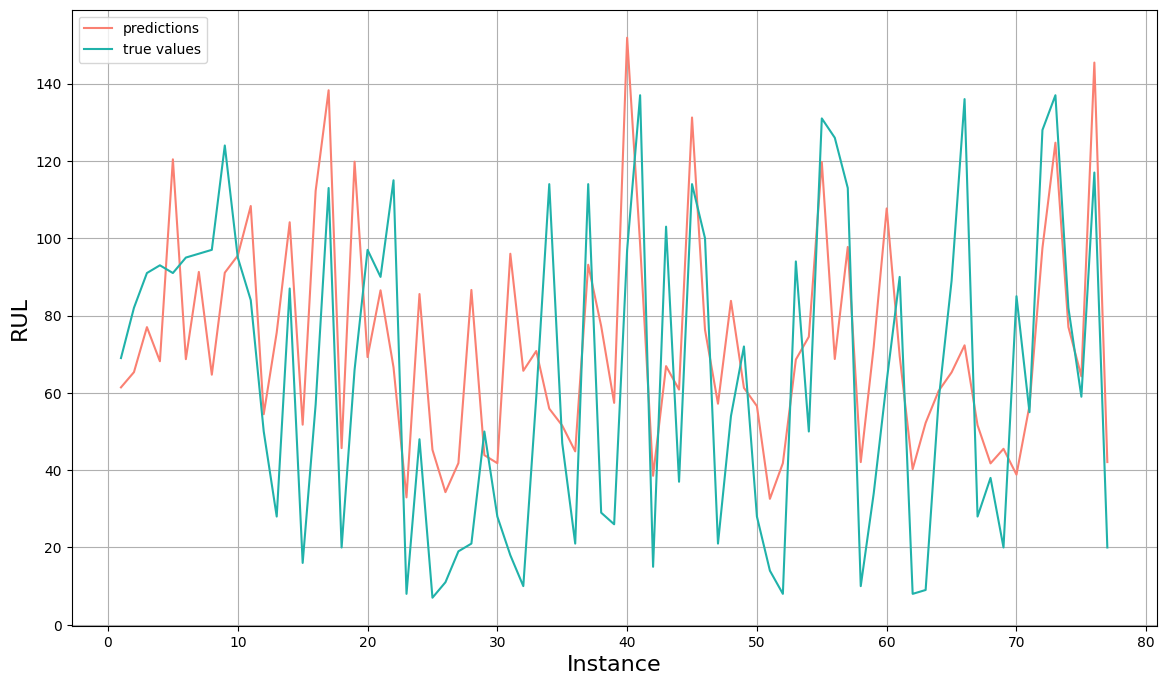

In [134]:
if DisplayGraph == 1:
    X_np, y_np = UtilsTool.prepare_batch(X.cpu().detach(), y.cpu())
    y_pred = UtilsTool.exp_degradation(X_np, *Param)
    UtilsTool.DisplayGraph(torch.tensor(y_pred).cpu(), y, FiguresPath, "NormalStatsDetection")

In [135]:
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataFgsm,  Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataBim, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataCW, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataMaillardL2, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataMaillardL0, Param))

print()
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataFgsm,  Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataBim, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataCW, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataMaillardL2, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataMaillardL0, Param))

print()
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataFgsm,  Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataBim, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataCW, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, Param))

{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 70.71940612792969, 'RMSE_adversarial': 0.05165189069609401, 'RMSE_pred': 31.190736770629883}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 62.29285430908203, 'RMSE_adversarial': 0.045485647770054184, 'RMSE_pred': 31.384836196899414}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 65.501220703125, 'RMSE_adversarial': 0.045177851187551826, 'RMSE_pred': 31.819381713867188}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 69.8340072631836, 'RMSE_adversarial': 0.028818127464820167, 'RMSE_pred': 32.074363708496094}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 69.76569366455078, 'RMSE_adversarial': 0.06714453728891985, 'RMSE_pred': 33.880821228027344}

{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 84.97969818115234, 'RMSE_adversarial': 0.05165018888200677, 'RMSE_pred': 38.684844970703125}
{'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 86.67813873291016, 'RMSE_adversarial': 0.0

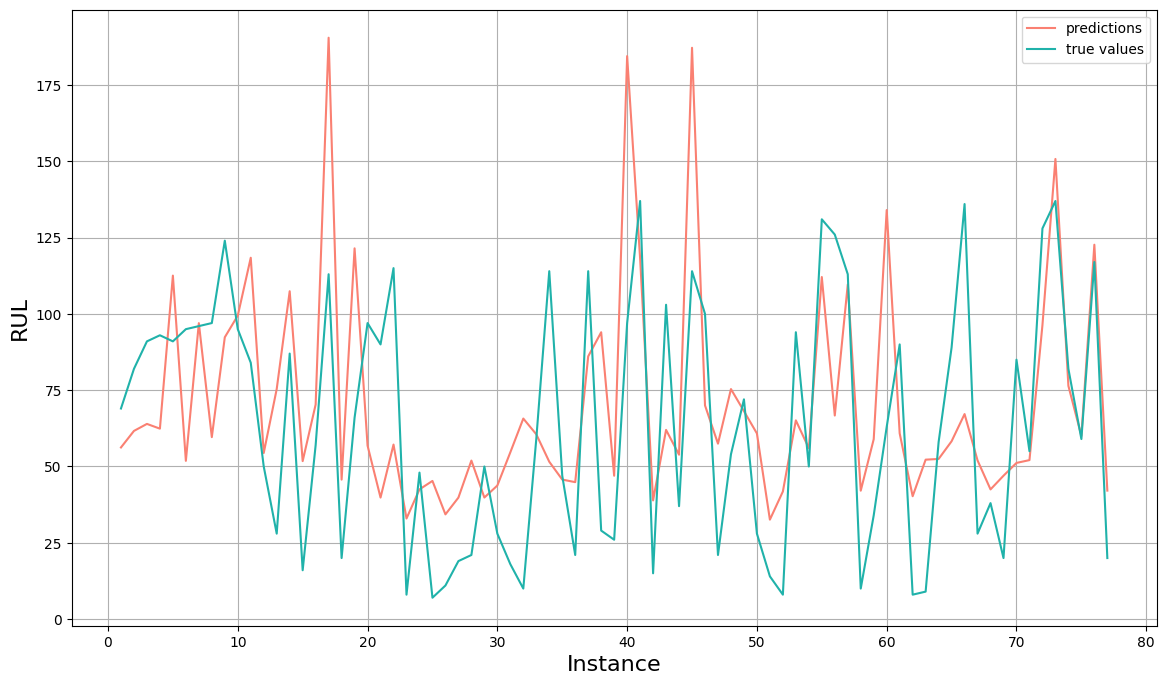

In [136]:
if DisplayGraph == 1:
    X_Adv_np, y_np = UtilsTool.prepare_batch(PLSTMAdversarialDataMaillardL0.cpu().detach(), y.cpu())
    y_pred = UtilsTool.exp_degradation(X_Adv_np, *Param)
    UtilsTool.DisplayGraph(torch.tensor(y_pred).cpu(), y, FiguresPath, "AdversarialRNNStatsDetection")